In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.style.use('seaborn-bright')
from datetime import timedelta
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import *
import seaborn as sns

In [2]:
# Load Dataset
data = pd.read_csv('QBElecWeather.csv')
# HUElec = pd.melt(data, id_vars=["Date"], var_name='time')
# HUElec['time'] = pd.to_timedelta(HUElec['time'].apply(lambda t: f"{t[:5]}:00")) - timedelta(minutes=30)
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%Y/%m/%d")
# HUElec['Datetime'] = HUElec['Date'] + HUElec['time']
HUElec = data.set_index('Datetime')
# HUElec = HUElec.drop(['Date', 'time'], axis=1).sort_index()

# View formatted data
HUElec.head()

,KW/h,temp,dew_point,pressure,humidity,wind_speed
Datetime,,,,,,
2008-03-03 00:00:00,0.0,6.34,2.97,1009,79,6.72
2008-03-03 01:00:00,0.0,5.50,2.50,1009,81,6.82
2008-03-03 02:00:00,0.0,5.21,1.33,1010,76,6.75
2008-03-03 03:00:00,0.0,4.54,0.13,1010,73,6.58
2008-03-03 04:00:00,0.0,3.84,-0.32,1010,74,6.55


In [3]:
df = HUElec.copy()

# df = data.resample(rule='H').sum()
untouched = HUElec.copy()
df.index

DatetimeIndex(['2008-03-03 00:00:00', '2008-03-03 01:00:00',
               '2008-03-03 02:00:00', '2008-03-03 03:00:00',
               '2008-03-03 04:00:00', '2008-03-03 05:00:00',
               '2008-03-03 06:00:00', '2008-03-03 07:00:00',
               '2008-03-03 08:00:00', '2008-03-03 09:00:00',
               ...
               '2022-03-01 14:00:00', '2022-03-01 15:00:00',
               '2022-03-01 16:00:00', '2022-03-01 17:00:00',
               '2022-03-01 18:00:00', '2022-03-01 19:00:00',
               '2022-03-01 20:00:00', '2022-03-01 21:00:00',
               '2022-03-01 22:00:00', '2022-03-01 23:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=122688, freq=None)

In [4]:
# df['Hour'] = df.index.hour
# df['day_of_week'] = df.index.day_name()
# df['day_of_month'] = df.index.day
# df['month'] = df.index.month

In [5]:
df.head()

,KW/h,temp,dew_point,pressure,humidity,wind_speed
Datetime,,,,,,
2008-03-03 00:00:00,0.0,6.34,2.97,1009,79,6.72
2008-03-03 01:00:00,0.0,5.50,2.50,1009,81,6.82
2008-03-03 02:00:00,0.0,5.21,1.33,1010,76,6.75
2008-03-03 03:00:00,0.0,4.54,0.13,1010,73,6.58
2008-03-03 04:00:00,0.0,3.84,-0.32,1010,74,6.55


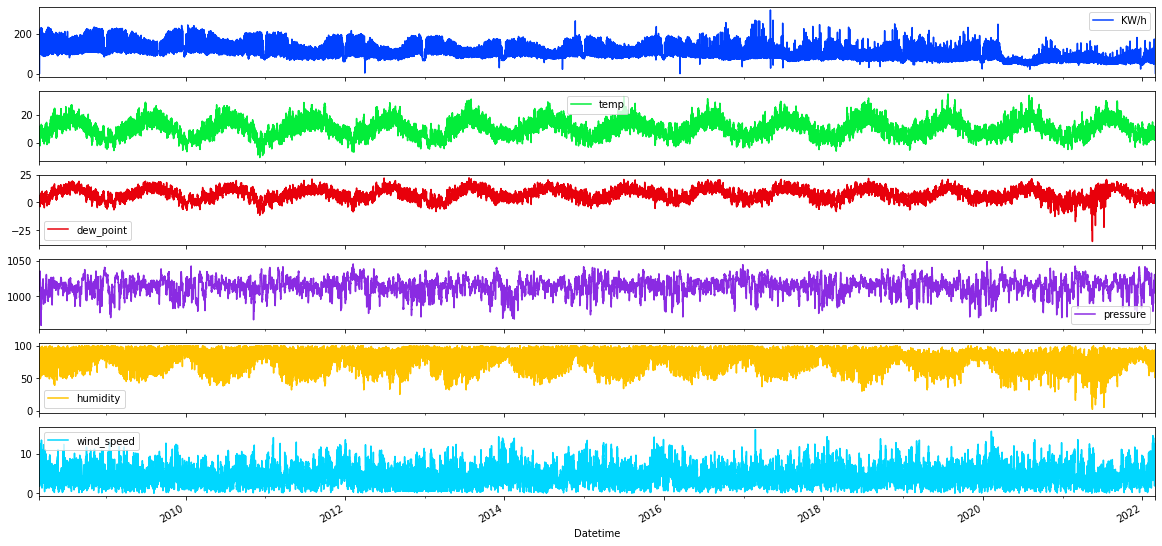

In [6]:
# sns.lineplot(x=df.index, y='KW/h', data=df, label='KW/h')

df.plot(subplots=True, figsize=(20,10));

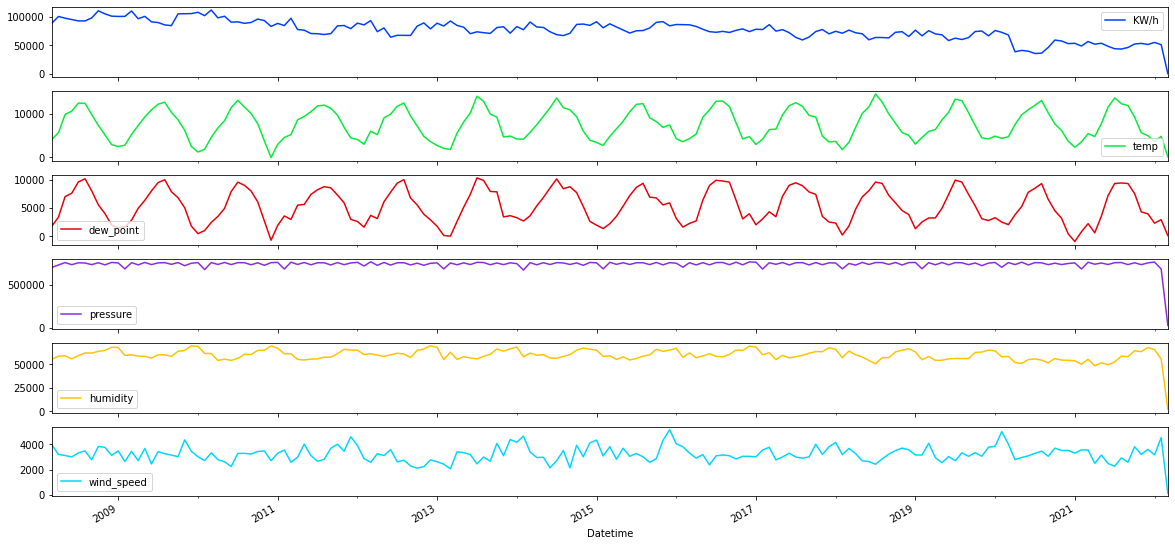

In [7]:
df_by_month = df.resample(rule='M').sum()
df_by_month.plot(subplots=True, figsize=(20,10));
# sns.lineplot(x=df_by_month.index, y='KW/h', data=df_by_month)

In [8]:
# sns.pointplot(data=df, x='Hour', y='KW/h');

In [9]:
# sns.pointplot(data=df, x='Hour', y='KW/h', hue='day_of_week');

In [10]:
# sns.pointplot(data=df, x='day_of_week', y='KW/h');

In [11]:
# Splitting the data
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

print(train.shape, test.shape)

(98150, 6) (24538, 6)


In [12]:
f_columns = ['temp', 'dew_point', 'pressure', 'humidity', 'wind_speed']

f_transformer = RobustScaler()
value_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
value_transformer = value_transformer.fit(train[['KW/h']])

train.loc[:,f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['KW/h'] = value_transformer.transform(train[['KW/h']])

test.loc[:,f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['KW/h'] = value_transformer.transform(test[['KW/h']])

C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-12-42539fb70ff8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['KW/h'] = value_transformer.transform(train[['KW/h']])
C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [13]:
def create_dataset(X, y, time_step=1):
    Xs, ys = [], []

    for i in range(len(X) - time_step):
        v = X.iloc[i:(i+time_step)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_step])

    return np.array(Xs), np.array(ys)

In [14]:
TIME_STEPS = 24 # Taking 10 hour time steps to predict the next hour

X_train, y_train = create_dataset(train, train['KW/h'], time_step=TIME_STEPS)
X_test, y_test = create_dataset(test, test['KW/h'], time_step=TIME_STEPS)

In [15]:
# create_dataset converts the data to this format [samples, time_steps, n_features]

print(X_train.shape, y_train.shape)

(98126, 24, 6) (98126,)


In [16]:
print(X_test.shape, y_test.shape)

(24514, 24, 6) (24514,)


In [17]:
X_train[0][0].shape

(6,)

In [21]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1))
# model.summary()
# model = Sequential()
# model.add(LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(LSTM(units=128, activation='relu', return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(LSTM(units=128, activation='relu', return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(LSTM(units=64, activation='relu', return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(LSTM(units=64, activation='relu', return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(LSTM(units=32, activation='relu'))
# model.add(Dropout(rate=0.2))
# model.add(Dense(units=1))
# model.summary()

In [22]:
from keras.callbacks import *

es = EarlyStopping(monitor='val_loss', patience=2)

In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1, callbacks=es, shuffle=False)

Epoch 1/50
1380/1380 [==============================] - 75s 35ms/step - loss: 0.1442 - val_loss: 0.0370
Epoch 2/50
1380/1380 [==============================] - 40s 29ms/step - loss: 0.0304 - val_loss: 0.0311
Epoch 3/50
1380/1380 [==============================] - 40s 29ms/step - loss: 0.0256 - val_loss: 0.0295
Epoch 4/50
1380/1380 [==============================] - 40s 29ms/step - loss: 0.0244 - val_loss: 0.0279
Epoch 5/50
1380/1380 [==============================] - 39s 29ms/step - loss: 0.0236 - val_loss: 0.0278
Epoch 6/50
1380/1380 [==============================] - 41s 30ms/step - loss: 0.0216 - val_loss: 0.0273
Epoch 7/50
1380/1380 [==============================] - 41s 29ms/step - loss: 0.0207 - val_loss: 0.0264
Epoch 8/50
1380/1380 [==============================] - 40s 29ms/step - loss: 0.0194 - val_loss: 0.0257
Epoch 9/50
1380/1380 [==============================] - 40s 29ms/step - loss: 0.0185 - val_loss: 0.0255
Epoch 10/50
1380/1380 [==============================] - 40s 29m

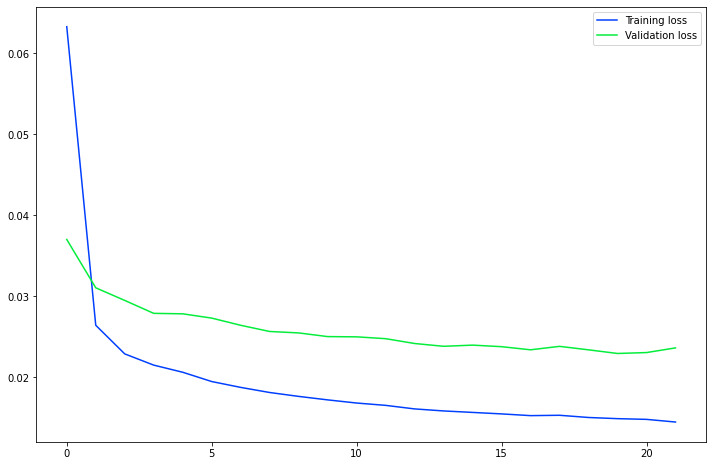

In [25]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [26]:
y_pred = model.predict(X_test)

In [27]:
y_train_inv = value_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = value_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = value_transformer.inverse_transform(y_pred)

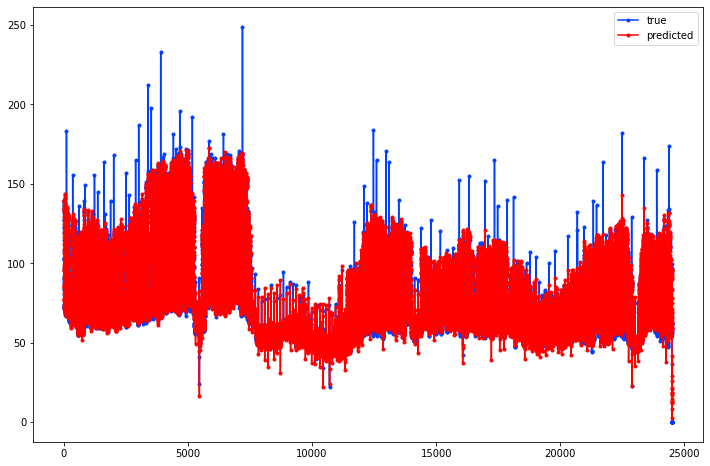

In [28]:
plt.plot(y_test_inv.flatten(), marker='.', label='true')
plt.plot(y_pred_inv.flatten(), marker='.', color='r', label='predicted')
plt.legend();